# Mini Project Part B

This is a template for Part B of your project. It builds on Part A that you have solved earlier this term. 

You are provided with the code to
* load and prepare the data
* evaluate your classifiers
* train and evaluate a benchmark classifier

Your tasks are to
* implement two advanced classifiers using variety of techniques from **weeks 4-9** which may include dimensionality reduction, random forests, ensembles, feature selection and neural networks.
* analyse the performance of your classifiers and compare them to the benchmark classifier
* discover the most important features (brain connections) that drive differences between term and preterm babies

For each task you need to either write code in the 'Code' cell or answer the question in the 'Markdown' cell. There is a word limit to discourage lengthy commentaries. Be brief and clear.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings("ignore")

## Load and prepare data

You already know this dataset from part A. However this time, the dataset has been split in advance into training and test set. The code below loads the **training dataset** for you. You will be given the test dataset at the end of the notebook.

(341, 90, 90)


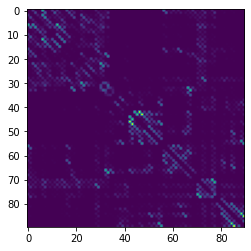

In [2]:
# load connectivity matrices
import pickle
matrices = pickle.load( open( "data/matrices_train.p", "rb" ) )
print(matrices.shape)
plt.imshow(matrices[1,:,:])

In [3]:
# convert upper triangles of the matrices to feature vectors

# dimensions
n = matrices.shape[0]
m = matrices.shape[1]
D = round(m*(m-1)/2)
print('n={}, D={}'.format(n,D))

# feature matrix
X=np.zeros([n,D])
for i in range(n):
    index=0
    for j in range(m):
        for k in range(j):
            X[i,index]=matrices[i,j,k]
            index=index+1
print(X.shape)

n=341, D=4005
(341, 4005)


In [4]:
# load subject info
subject_info = pd.read_csv('data/subject_info_train.csv')
subject_info

,age,prematurity
0,39,1
1,41,1
2,41,1
3,41,1
4,44,1
...,...,...
336,43,0
337,44,0
338,44,0
339,44,0


In [5]:
# load gray matter region descriptions - you will need this in for discovery of important discriminative features
label_names = pd.read_csv('data/label_names.csv')
label_names

,Label,Region name,Region description
0,1.0,Precentral_L,Precental gyrus
1,2.0,Precentral_R,Precental gyrus
2,3.0,Frontal_Sup_L,"Superior frontal gyrus, dorsolateral"
3,4.0,Frontal_Sup_R,"Superior frontal gyrus, dorsolateral"
4,5.0,Frontal_Sup_Orb_L,"Superior frontal gyrus, orbital part"
...,...,...,...
85,86.0,Temporal_Mid_R,Middle temporal gyrus
86,87.0,Temporal_Pole_Mid_L,Temporal pole: middle temporal gyrus
87,88.0,Temporal_Pole_Mid_R,Temporal pole: middle temporal gyrus
88,89.0,Temporal_Inf_L,Inferior temporal gyrus


Prepare the feature matrix and label vector

In [6]:
# Preprocessing

from sklearn.preprocessing import StandardScaler

# Use feature matrix X and scale the features
X = StandardScaler().fit_transform(X)

# Extract label vector
y = subject_info.to_numpy()[:,1]

## Evaluation framework

In [7]:
# Evaluation using predicted labels
# use to calculate training and test performance
# also validation performance when we have a single validation set (e.g. neural networks)
# can be used for sklearn and torch (make sure y_pred is converted to numpy or tensors with no gradients)

from sklearn.metrics import recall_score
from sklearn.metrics import accuracy_score

def evaluation(y,y_pred):
    # accuracy
    accuracy = accuracy_score(y,y_pred)
    print('accuracy: ', round(accuracy,2))
    # sensitivity: pos_label = 1
    sensitivity = recall_score(y,y_pred)
    print('sensitivity: ',round(sensitivity,2))
    # pos_label = 0 gives specificity
    specificity = recall_score(y,y_pred,pos_label = 0)
    print('specificity: ',round(specificity,2))
    # average recall 
    mean_recall = recall_score(y,y_pred,average='macro')
    print('mean recall: ',round(mean_recall,2))

In [8]:
# Evaluation using cross-validation
# use to calculate cross-validated performance on training set
# never use on test set
# only compatible with sklearn but not torch

from sklearn.model_selection import cross_val_predict


def evaluationCV(model,X,y):

    # predict using cross-validation
    y_pred = cross_val_predict(model,X,y)

    # accuracy
    accuracy = accuracy_score(y,y_pred)
    print('CV accuracy: ', round(accuracy,2))    
    # sensitivity: pos_label = 1
    sensitivity = recall_score(y,y_pred)
    print('CV sensitivity: ',round(sensitivity,2))
    # pos_label = 0 gives specificity
    specificity = recall_score(y,y_pred,pos_label = 0)
    print('CV specificity: ',round(specificity,2))
    # average recall
    mean_recall = recall_score(y,y_pred,average='macro')
    print('CV mean recall: ',round(mean_recall,2))   

## Benchmark classifier

We train a simple **logistic regression classifier** as our benchmark model, to compare performance of the advanced models. This classifier
* deals with the problem of large number of features (4005) compared to the small number of training samples (341) by using __ridge regularisation__
* tunes regularisation parameter `C` using __cross-validated accuracy__
* does not address the data imbalance

In [9]:
# Train Logistic regression classifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV

model = LogisticRegression()
param_grid = {"C": np.logspace(-3, 3, 13)}
grid_search = GridSearchCV(model, cv=5, param_grid=param_grid) 
_=grid_search.fit(X,y) 

print('Best C  :', grid_search.best_estimator_.C) 
print('Best CV accuracy:', round(grid_search.best_score_,2))

# best model
classifier_benchmark = grid_search.best_estimator_

Best C  : 10.0
Best CV accuracy: 0.91


In [10]:
print('Training performance:')
y_pred = classifier_benchmark.predict(X)
evaluation(y,y_pred)

Training performance:
accuracy:  1.0
sensitivity:  1.0
specificity:  1.0
mean recall:  1.0


In [11]:
print('Cross-validated performance on training set:')
evaluationCV(classifier_benchmark,X,y)

Cross-validated performance on training set:
CV accuracy:  0.91
CV sensitivity:  0.66
CV specificity:  0.97
CV mean recall:  0.81


**Analysis of the performance:**
* Training performance is very high, and much higher than CV performance, we see that the model still **overfits** the data
* CV accuracy is good (91%), however we have **low sensitivity**, probably due to data imballance and overlap between two classes


## 1. Your Classifier 1

**30 marks**

**Task 1.1:** Train and tune your first advanced classifier. Make sure you print out any tuned parameters.

In [14]:
# Create and train classifier 1 (Multi-layer Perceptron)

from sklearn.neural_network import MLPClassifier
from imblearn.over_sampling import SMOTE

oversample = SMOTE()
XOversampled, yOversampled = oversample.fit_resample(X, y)

model_1 = MLPClassifier()
params_1 = {"activation" : ['identity', 'logistic', 'tanh', 'relu'], 
           "solver" : ['lbfgs', 'sgd', 'adam'], 
           "learning_rate" : ['constant', 'invscaling', 'adaptive'],
           "max_iter" : [100, 200, 300]}

gridSearch_1 = GridSearchCV(model_1, param_grid = params_1) 
gridSearch_1.fit(XOversampled, yOversampled) 

# Print best CV metric and tuned parameters

print('Best activation: ', gridSearch_1.best_estimator_.activation)
print('Best solver: ', gridSearch_1.best_estimator_.solver)
print('Best learning_rate: ', gridSearch_1.best_estimator_.learning_rate)
print('Best max_iter: ', gridSearch_1.best_estimator_.max_iter)
print('Best CV accuracy:', round(gridSearch_1.best_score_,2))

# save your best model 1
classifier1 = gridSearch_1.best_estimator_

Best activation:  relu
Best solver:  lbfgs
Best learning_rate:  invscaling
Best max_iter:  300
Best CV accuracy: 0.96


**Task 1.2: Describe the main features of your classifier and how they address the challenges of overfitting, class imbalance and class overlap [max 100 words]:**

Considering hardware limitations along with the classifier used, the main features are 'activation', 'solver', 'learning_rate' and 'max_iter'. The 'solver' is for weight optimization and and along with 'max_iter' yields good results. The 'learning_rate' and 'activation' also deviate from its default value demonstrating that tuning these hyperparameters gives acceptable results on 'evaluationCV' with seen data.

- Overfitting has not been addressed in this classifier.
- Synthetic Minority Oversampling Technique (SMOTE) has been used to tackle class imbalance.
- Class Overlap has not been addressed in this classifier (can be observed in the plots).

Run the cell to evaluate **training performance** of your classifier:

*Note: You need to amend this if using Pytorch*

In [15]:
y_pred = classifier1.predict(X)
evaluation(y,y_pred)

accuracy:  1.0
sensitivity:  1.0
specificity:  1.0
mean recall:  1.0


Run the cell to evaluate **CV performance** of your classifier:

*Note: You need to amend this if using Pytorch*

In [16]:
evaluationCV(classifier1,X,y)

CV accuracy:  0.88
CV sensitivity:  0.74
CV specificity:  0.91
CV mean recall:  0.82


**Task 1.3: Analyse performance of your new classifier and compare it to the benchmark classifier [max 50 words]:**
* Training performance is very high and higher than CV performance. We see that the classifier still **overfits** the data.
* CV accuracy is good (88%). However we have **low sensitivity** but, it is better than the benchmark classifier which means this classifier (MLP) is able to predict 'preterm' better than benchmark classifier.

## 2. Your Classifier 2

**30 marks**

**Task 2.1:** Train and tune your first advanced classifier. Make sure you print out any tuned parameters.

In [40]:
# Create and train classifier 2 (AdaBoost)

from sklearn.ensemble import AdaBoostClassifier
from imblearn.over_sampling import SMOTE
from sklearn.feature_selection import SelectFromModel
from sklearn.linear_model import LogisticRegression

selector = SelectFromModel(AdaBoostClassifier(), threshold = 0.01)
XSelected = selector.fit_transform(X, y)

oversample = SMOTE()
XOversampled, yOversampled = oversample.fit_resample(XSelected, y)

model_2 = AdaBoostClassifier()
params_2 = {"n_estimators" : [70,90,100,120,150]}

gridSearch_2 = GridSearchCV(model_2, param_grid=params_2) 
gridSearch_2.fit(XOversampled, yOversampled)

# Print best CV metric and tuned parameters

print('Best n_estimator: ', gridSearch_2.best_estimator_.n_estimators)
print('Best CV accuracy: ', round(gridSearch_2.best_score_,2))

# save your best model 2
classifier2 = gridSearch_2.best_estimator_

Best n_estimator:  150
Best CV accuracy:  1.0


In [42]:
print(XSelected.shape)

(341, 46)


**Task 2.2: Describe the main features of your classifier and how they address the challenges of overfitting, class imbalance and class overlap [max 100 words]:**

The most important feature of this classifier is 'n_estimator'. Of the very few parameters that AdaBoostClassifier offers, it was observed while tuning that these parameters tend to lean towards default value. Tuning 'n_estimator' yields very good performance on 'evaluationCV' with seen data.

- Overfitting has not been addressed in this classifier.
- Synthetic Minority Oversampling Technique (SMOTE) has been used to tackle class imbalance.
- Class Overlap has been addressed in this classifier mostly due to feature selection using 'SelectFromModel' (can be observed in the plots). The model used for this was again 'AdaBoostClassifier' as it helps with reducing features to almost 1% of the original number of features when compared to using models such as 'LogisticRegression'.

Run the cell to evaluate **training performance** of your classifier:

*Note: You need to amend this if using Pytorch*

In [43]:
y_pred = classifier2.predict(XSelected)
evaluation(y,y_pred)

accuracy:  1.0
sensitivity:  1.0
specificity:  1.0
mean recall:  1.0


Run the cell to evaluate **CV performance** of your classifier:

*Note: You need to amend this if using Pytorch*

In [44]:
evaluationCV(classifier2,XSelected,y)

CV accuracy:  0.96
CV sensitivity:  0.82
CV specificity:  1.0
CV mean recall:  0.91


**Task 2.3: Analyse performance of your new classifier 2 and compare it to the benchmark classifier [max 50 words]:**
* Training performance is very high and higher than CV performance. We see that the classifier still **overfits** the data but not as highly as benchmark classifier.
* CV accuracy is very good (96%). Can observe **high specificity**. We have achieved **decent sensitivity**  and it is better than the benchmark classifier which means this classifier (AdaBoost) is able to predict 'preterm' much better than benchmark classifier.


**Task 2.4: Compare performance of your new classifier 2 your classifier 1 [max 50 words]:**
* Training performance is very high for both the classifiers and also much higher than CV performance. Both the classifiers **overfit** the data.
* CV accuracy of classifier2 is better than classifier1. The **sensitivity** for classifier2 is also higher than classifier1. This is mostly because of the extreme feature selection (4005 to 46) as class imbalance was addressed for both the classifiers.

## 3. Analyse the results

### Discover the most predictive features
**10 marks**

**Task 3.1:** Print out most predictive features of at least one of your models.

In [49]:
# Identify and print the most important predictive features

selectedIndex = selector.get_support(indices=True)

#create an empty list to append important feature indices
labelIndices = []

for i in range(n):
    index=0
    for j in range(m):
        for k in range(j):
            X[i,index]=matrices[i,j,k]
            if index in selectedIndex:
                labelIndices.append(j+1)
                labelIndices.append(k+1)
            index=index+1

labelIndices = list(set(labelIndices))

#create an empty list to append common rows from label_names
labelCompare = []

for row in label_names.iterrows():
    if row[0] in labelIndices:
        labelCompare.append(row[1])

#print the dataframe of important labels
region_names = pd.DataFrame(labelCompare)
region_names

,Label,Region name,Region description
1,2.0,Precentral_R,Precental gyrus
3,4.0,Frontal_Sup_R,"Superior frontal gyrus, dorsolateral"
5,6.0,Frontal_Sup_Orb_R,"Superior frontal gyrus, orbital part"
7,8.0,Frontal_Mid_R,Middle frontal gyrus
9,10.0,Frontal_Mid_Orb_R,"Middle frontal gyrus, orbital part"
12,13.0,Frontal_Inf_Tri_L,"Inferior frontal gyrus, triangular part"
13,14.0,Frontal_Inf_Tri_R,"Inferior frontal gyrus, triangular part"
14,15.0,Frontal_Inf_Orb_L,"Inferior frontal gyrus, orbital part"
17,18.0,Rolandic_Oper_R,Rolandic operculum
19,20.0,Supp_Motor_Area_R,Supplementary motor area


### Plot the results
**15 marks**

**Task 3.2:** Demonstrate the fit using your best performing classifier(s). For example, you can use PCA to display results, but you can also come up with an original technique that we have not used before.

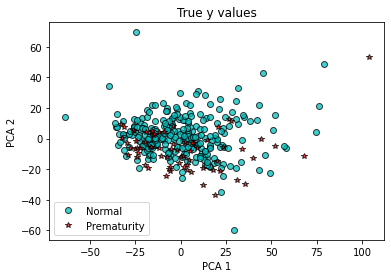

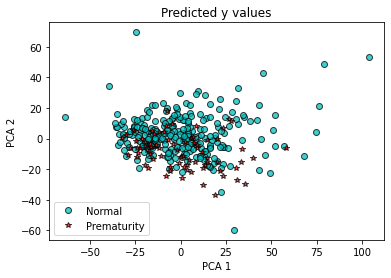

In [20]:
# Plot the results for classifier 1 (MLP)

from sklearn.decomposition import PCA

model = PCA(n_components = 2)
reducedXtrain = model.fit_transform(X)

# plot the training and test data
plt.plot(reducedXtrain[y==0,0], reducedXtrain[y==0,1], "co", alpha=0.75, markeredgecolor='k', label = 'Normal')
plt.plot(reducedXtrain[y==1,0], reducedXtrain[y==1,1], "r*", alpha=0.75, markeredgecolor='k', label = 'Prematurity')
plt.legend()
plt.title('True y values')
plt.xlabel('PCA 1')
plt.ylabel('PCA 2')
plt.show()

y_pred = cross_val_predict(classifier1,X,y)

# plot the training and test data
plt.plot(reducedXtrain[y_pred==0,0], reducedXtrain[y_pred==0,1], "co", alpha=0.75, markeredgecolor='k', label = 'Normal')
plt.plot(reducedXtrain[y_pred==1,0], reducedXtrain[y_pred==1,1], "r*", alpha=0.75, markeredgecolor='k', label = 'Prematurity')
plt.legend()
plt.title('Predicted y values')
plt.xlabel('PCA 1')
plt.ylabel('PCA 2')
plt.show()

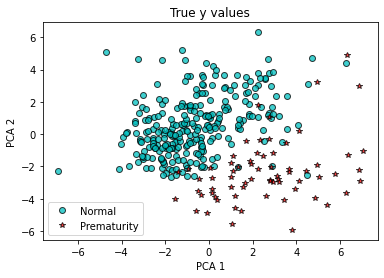

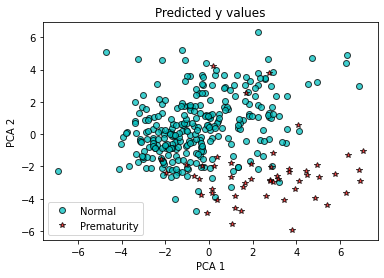

In [41]:
# Plot the results for classifier 2 (AdaBoost)

from sklearn.decomposition import PCA

model = PCA(n_components = 2)
reducedXtrain = model.fit_transform(XSelected)

# plot the training and test data
plt.plot(reducedXtrain[y==0,0], reducedXtrain[y==0,1], "co", alpha=0.75, markeredgecolor='k', label = 'Normal')
plt.plot(reducedXtrain[y==1,0], reducedXtrain[y==1,1], "r*", alpha=0.75, markeredgecolor='k', label = 'Prematurity')
plt.legend()
plt.title('True y values')
plt.xlabel('PCA 1')
plt.ylabel('PCA 2')
plt.show()

y_pred = cross_val_predict(classifier2,X,y)

# plot the training and test data
plt.plot(reducedXtrain[y_pred==0,0], reducedXtrain[y_pred==0,1], "co", alpha=0.75, markeredgecolor='k', label = 'Normal')
plt.plot(reducedXtrain[y_pred==1,0], reducedXtrain[y_pred==1,1], "r*", alpha=0.75, markeredgecolor='k', label = 'Prematurity')
plt.legend()
plt.title('Predicted y values')
plt.xlabel('PCA 1')
plt.ylabel('PCA 2')
plt.show()

**Task 3.3: Interpret your plots [max 50 words]:**

- Plots on classifier1 (MLP) clearly demonstrate class overlap. But this is expected as there are a large number of features. Also it seems that high performance cannot be achieved due the inseperable nature of the dataset.
- Plots on classifier2 (AdaBoost) seem to have very less overlap when compared to classifier1. This is due to low number of features which were selected using 'SelectFromModel'.

It can also be observed (between classifier1 and classifier2) that when the features are reduced there is a clear increase in performance on 'evaluationCV' metrics. 

## 4. Evaluate on the test set
**15 marks**

Finally, we will evaluate performance of our classifiers on the test set. The cell below loads the test set for you.

*Note: You are not allowed to use the test set anywhere else except for this section*

In [17]:
# load connectivity matrices
import pickle
matrices_test = pickle.load( open( "data/matrices_test.p", "rb" ) )

# convert upper triangles of the matrices to feature vectors
n = matrices_test.shape[0]
m = matrices_test.shape[1]
D = round(m*(m-1)/2)
X_test=np.zeros([n,D])
for i in range(n):
    index=0
    for j in range(m):
        for k in range(j):
            X_test[i,index]=matrices_test[i,j,k]
            index=index+1

# load subject info
subject_info_test = pd.read_csv('data/subject_info_test.csv')


# Preprocessing
from sklearn.preprocessing import StandardScaler
X_test = StandardScaler().fit_transform(X_test)
y_test = subject_info_test.to_numpy()[:,1]
print('X_test: ',X_test.shape)
print('y_test: ', y_test.shape)

X_test:  (92, 4005)
y_test:  (92,)


Run the cell below to evaluate performance of the **benchmark classifier**.

In [18]:
y_pred_test_benchmark = classifier_benchmark.predict(X_test)
evaluation(y_test,y_pred_test_benchmark)

accuracy:  0.89
sensitivity:  0.68
specificity:  0.95
mean recall:  0.81


**Task 4.1:** Evaluate performance of **your classifier 1** on the test set

In [38]:
y_pred_test_1 = classifier1.predict(X_test)
evaluation(y_test,y_pred_test_1)

accuracy:  0.9
sensitivity:  0.84
specificity:  0.92
mean recall:  0.88


**Task 4.2:** Evaluate performance of **your classifier 2** on the test set

In [45]:
XTestSelected = selector.transform(X_test)

y_pred_test_2 = classifier2.predict(XTestSelected)
evaluation(y_test,y_pred_test_2)

accuracy:  0.89
sensitivity:  0.68
specificity:  0.95
mean recall:  0.81


**Task 4.3: Analyse performance of your classifiers on the test set and recommend the best technique [max 100 words]:**

Classifier 1 (MLP) - Yields superior performance when compared to benchmark classifier on test set.

- Good accuracy (90%) and **decent sensitivity** of 0.84 has been achieved. There is a small tradeoff between specificity but it is negligible. Mean recall is very good as well. 
- Model able to identify true positive and true negative with almost equal probability . On unseen data, the model performs well.

Classifier 2 (AdaBoost) - Yields exact same performance when compared to benchmark classifier on test set.

- Good accuracy (89%) and **low sensitivity** of 0.68 has been achieved. Specificity and mean recall are acceptable.
- Although model predicts true negative very well, it cannot identify true positive accurately. Hence, we can safely say that on unseen data the model does not perform well.

The best technique of the above to classifiers would be Multi-layer Perceptron (MLPClassifier) as it performs extremely well on unseen data.
